In [66]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
import os
import joblib
from sklearn.metrics import r2_score
import matplotlib.dates as mdates

In [67]:
plt.rcParams["axes.unicode_minus"] = False

if platform.system() == "Darwin":  # macOS
    rc("font", family="AppleGothic")
elif platform.system() == "Windows":  # Windows
    font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc("font", family=font_name)
elif platform.system() == "Linux":  # Linux (Ubuntu, Docker 등)
    font_path = "fonts/NanumGothic.ttf"
    if not os.path.exists(font_path):
        st.error("NanumGothic.ttf 폰트 파일이 존재하지 않습니다. 'fonts' 폴더 내에 폰트 파일을 확인하세요.")
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc("font", family=font_name)

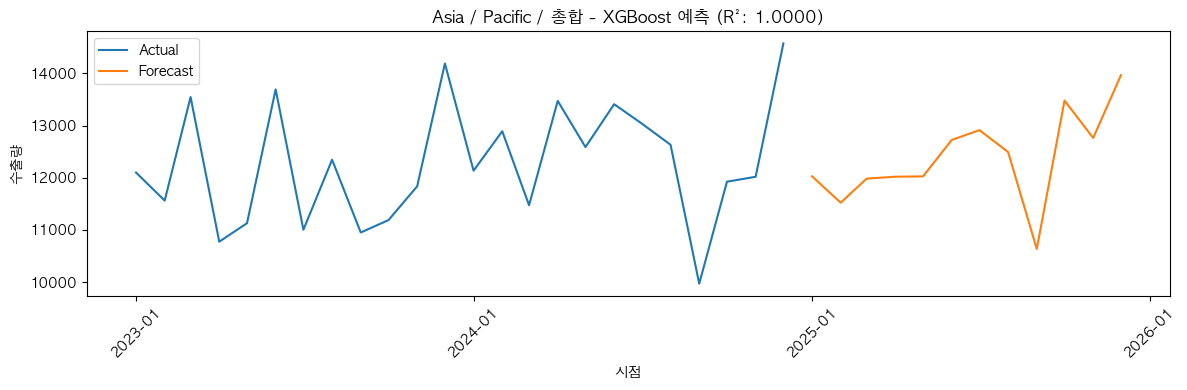


🔧 학습 R² Score: 1.0000
2025-03월 예측: 12,026.54
2025-04월 예측: 11,521.03
2025-05월 예측: 11,982.65
2025-06월 예측: 12,019.13
2025-07월 예측: 12,025.37
2025-08월 예측: 12,723.10
2025-09월 예측: 12,911.36
2025-10월 예측: 12,492.16
2025-11월 예측: 10,636.03
2025-12월 예측: 13,477.73
2026-01월 예측: 12,761.55
2026-02월 예측: 13,963.74


In [78]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# 1. 데이터 불러오기
df = pd.read_csv('../../data/processed/기아_지역별수출실적_전처리.CSV')

month_cols = ['1월','2월','3월','4월','5월','6월',
              '7월','8월','9월','10월','11월','12월']

# 0을 np.nan으로 변환
df[month_cols] = df[month_cols].replace(0, np.nan)

df[month_cols] = df[month_cols].apply(lambda x: x.astype(str).str.replace(',', ''))
df[month_cols] = df[month_cols].apply(pd.to_numeric, errors='coerce')
df[month_cols] = df[month_cols].replace(0, np.nan)
df[month_cols] = df[month_cols].interpolate(method='linear', axis=1, limit_direction='both')

def create_regression_dataset(series, window_size=12):
    X, y = [], []
    for i in range(len(series) - window_size):
        if np.isnan(series[i:i+window_size+1]).any():
            continue
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

def predict_with_xgboost(df, country, vehicle_type, n_months=12, window_size=12):
    sub_df = df[(df['국가명'] == country) & (df['차량 구분'] == vehicle_type)]
    ts = sub_df[month_cols].values.flatten()

    if len(ts) < window_size + n_months:
        print("❌ 데이터 부족")
        return

    X, y = create_regression_dataset(ts, window_size)
    model = xgb.XGBRegressor(objective='reg:squarederror')
    model.fit(X, y)

    # 학습 평가 (R² Score)
    y_pred_train = model.predict(X)
    r2 = r2_score(y, y_pred_train)

    # 미래 예측
    input_seq = ts[-window_size:].tolist()
    predictions = []

    for _ in range(n_months):
        X_input = np.array(input_seq[-window_size:]).reshape(1, -1)
        y_pred = model.predict(X_input)[0]
        predictions.append(y_pred)
        input_seq.append(y_pred)

    # 전체 예측 구간 날짜 생성
    start_date = pd.to_datetime("2023-01-01")  # 예시: 시작 연도
    n_total = len(ts) + n_months
    date_range = pd.date_range(start=start_date, periods=n_total, freq='MS')

    plt.figure(figsize=(12, 4))
    plt.plot(date_range[:len(ts)], ts, label='Actual')
    plt.plot(date_range[len(ts):], predictions, label='Forecast')

    # 날짜 포맷 변경
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.xticks(rotation=45)

    plt.title(f"{country} / {vehicle_type} - XGBoost 예측 (R²: {r2:.4f})")
    plt.xlabel("시점")
    plt.ylabel("수출량")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 출력
    print(f"\n🔧 학습 R² Score: {r2:.4f}")
    for i, val in enumerate(predictions):
        print(f"{2025 + (i+2)//12}-{(3 + i - 1)%12 + 1:02d}월 예측: {val:,.2f}")

predict_with_xgboost(df, country="Asia / Pacific", vehicle_type="총합", n_months=12)